In [1]:
from pyincore import IncoreClient
from pyincore import MappingSet, FragilityService, Dataset
from pyincore.analyses.buildingdamage.buildingdamage import BuildingDamage
from pyincore.analyses.housingunitallocation import HousingUnitAllocation
from pyincore.analyses.populationdislocation import PopulationDislocation
from pyincore.analyses.housingrecovery.housingrecovery import HousingRecovery

In [2]:
# Connect to IN-CORE service
client = IncoreClient()

Connection successful to IN-CORE services. pyIncore version detected: 1.3.0


# Building damage, Galveston, TX analysis

In [3]:
hazard_type = "hurricane"
# Galveston deterministic Hurricane, 3 datasets - Kriging
hazard_id = "5fa5a228b6429615aeea4410"

# Galveston, TX Building inventory
bldg_inv_id = "60354b6c123b4036e6837ef7"  # 19k buildings with age_group

# Hurricane building mapping (with equation)
mapping_id = "602c381a1d85547cdc9f0675"
fragility_service = FragilityService(client)
mapping_set = MappingSet(fragility_service.get_mapping(mapping_id))

bldg_dmg = BuildingDamage(client)
bldg_dmg.load_remote_input_dataset("buildings", bldg_inv_id)
bldg_dmg.set_input_dataset("dfr3_mapping_set", mapping_set)

result_name = "Galveston_bldg_dmg_result"

bldg_dmg.set_parameter("fragility_key", "Hurricane SurgeLevel and WaveHeight Fragility ID Code")
bldg_dmg.set_parameter("result_name", result_name)
bldg_dmg.set_parameter("hazard_type", hazard_type)
bldg_dmg.set_parameter("hazard_id", hazard_id)
bldg_dmg.set_parameter("num_cpu", 4)

# Run Building damage
bldg_dmg.run_analysis()

# Retrieve result dataset
building_dmg_result = bldg_dmg.get_output_dataset("ds_result")

# Convert dataset to Pandas DataFrame
bdmg_df = building_dmg_result.get_dataframe_from_csv(low_memory=False)

# Display top 5 rows of output data
bdmg_df[["guid", "DS_0", "DS_1", "DS_2", "DS_3", "haz_expose"]].head(5)

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...


,guid,DS_0,DS_1,DS_2,DS_3,haz_expose
0,b39dd67f-802e-402b-b7d5-51c4bbed3464,1.0,0,0,0.000000e+00,yes
1,e7467617-6844-437e-a938-7300418facb8,1.0,0,0,8.600000e-08,yes
2,d7ce12df-660d-42fc-9786-f0f543c00002,1.0,0,0,0.000000e+00,partial
3,74aac543-8aae-4779-addf-754e307a772b,1.0,0,0,0.000000e+00,partial
4,ed3147d3-b7b8-49da-96a9-ddedfccae60c,1.0,0,0,0.000000e+00,partial


# Housing Unit Allocation (HUA) analysis

In [4]:
housing_unit_inv = "5fc6ab1cd2066956f49e7a03"
# Address point inventory
address_point_inv = "5fc6aadcc38a0722f563392e"

# Create housing allocation
hua = HousingUnitAllocation(client)

# Load input dataset
hua.load_remote_input_dataset("housing_unit_inventory", housing_unit_inv)
hua.load_remote_input_dataset("address_point_inventory", address_point_inv)
hua.load_remote_input_dataset("buildings", bldg_inv_id)

result_name = "Galveston_HUA"

seed = 1238
iterations = 1

# Set analysis parameters
hua.set_parameter("result_name", result_name)
hua.set_parameter("seed", seed)
hua.set_parameter("iterations", iterations)

# Run Housing unit allocation analysis
hua.run_analysis()

# Retrieve result dataset
hua_result = hua.get_output_dataset("result")

# Convert dataset to Pandas DataFrame
hua_df = hua_result.get_dataframe_from_csv(low_memory=False)

hua_df[["guid", "numprec", "incomegroup"]].head()

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...
Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...
Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...


,guid,numprec,incomegroup
0,eca98323-d57f-4691-a340-b4e0e19c2346,2,15.0
1,eca98323-d57f-4691-a340-b4e0e19c2346,2,17.0
2,eca98323-d57f-4691-a340-b4e0e19c2346,1,17.0
3,eca98323-d57f-4691-a340-b4e0e19c2346,2,17.0
4,eca98323-d57f-4691-a340-b4e0e19c2346,2,17.0


# Population Dislocation analysis

In [5]:
# Block group data, IN-CORE_BGMAP_2021-01-19_GalvestonTX
bg_data = "603545f2dcda03378087e708" # prod
# Value loss parameters DS 0-3
value_loss = "60354810e379f22e16560dbd"

pop_dis = PopulationDislocation(client)

pop_dis.load_remote_input_dataset("block_group_data", bg_data)
pop_dis.load_remote_input_dataset("value_loss_param", value_loss)

pop_dis.set_input_dataset("building_dmg", building_dmg_result)
pop_dis.set_input_dataset("housing_unit_allocation", hua_result)

result_name = "galveston-pop-disl-results"
seed = 1111

pop_dis.set_parameter("result_name", result_name)
pop_dis.set_parameter("seed", seed)

pop_dis.run_analysis()

# Retrieve result dataset
pd_result = pop_dis.get_output_dataset("result")

# Convert dataset to Pandas DataFrame
pd_df = pd_result.get_dataframe_from_csv(low_memory=False)

pd_df[["guid", "dislocated"]].head()

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...
Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...


,guid,dislocated
0,eca98323-d57f-4691-a340-b4e0e19c2346,True
1,eca98323-d57f-4691-a340-b4e0e19c2346,False
2,eca98323-d57f-4691-a340-b4e0e19c2346,True
3,eca98323-d57f-4691-a340-b4e0e19c2346,True
4,eca98323-d57f-4691-a340-b4e0e19c2346,True


# Household recovery analysis

These housing recovery models based on Hamideh, S., Peacock, W. G., & Van Zandt, S. (2018) *Housing recovery after disasters: Primary versus seasonal/vacation housing markets in coastal communities. Natural Hazards Review* predict building values and value changes over time following a disaster event. The models are calibrated with respect to demographics, parcel data, and building value trajectories following Hurricane Ike (2008) in Galveston, Texas.

The models predict building value at the parcel level for 8 years of observation. The models rely on Census (Decennial or American Community Survey, ACS) and parcel data immediately prior to the disaster event (year -1) as inputs for prediction. The models predict building values for years 0 - the impact year - and years +1 through +6 - the 6 years following the disaster event.

**A note of caution on interpreting the example and results below and further guidance.** 

The models predict impacts to and recovery of builiding values resulting from a disaster event. The example provided in this notebook makes use of chained data provided through earlier sections of this notebook. Specifically, 2010 Decennial Census and Galveston County Appraisal District (GCAD) tax assessor data are used in the prior examples. 2010 is after Hurricane Ike and thus contains impacts resulting from Ike. Demographics may have changed from before Ike to after Ike. Building values, property characteristics, and whether a property exists before or after Ike are highly likely to be different. 

Therefore, the example provided below is purely demonstrative of the mechanics of using the model with chained data; that is, using outputs from other analysis (i.e., Building Damage, Housing Unit Allocation, Population Dislocation) as inputs for the Housing Recovery Models. 

Future use of these Housing Recovery Models for prediction in other communities should take care to use appropriate data. 
* In the case that building values are being predicted in a community where a disaster event has not yet happened, it may make sense to use the most current year or most currently available years of data as inputs. Interpretation will then determined on the base year used. For example, if 2022 tax assessor data and 2018-2022 ACS 5-year estimates are used, the base year will be 2022. Census data is typically not available for the current year and is delayed in distrubution for public use. In this case, the most recently available Census data, whether Decennial or ACS, should be used.
* In the case that building values are being predicted in a community where a disaster event has happened, tax assessor and Census data reflective of the community immediately prior to the disaster event are required. For example, if a hurricane impacts a community in the fall of 2022, tax assesor data from 2022 should work considering that tax assessments typically occur in the first half of the year and reflect conditions prior to the disaster event. For demographic data, 2018-2022 ACS 5-year estimates may still work, though some survey responses used in the estimates may be collected after the disaster event. It would be worth considering if using 2017-2021 ACS 5-year estimates or 2020 Decennial Census data to ensure that all demographic characteristics are pre-storm. 

**Conceptual variables needed for housing recovery model**
- **Damage**: measured by the estimated percent building value loss as a result from disaster impacts. Ranges from 0 to 100. (time-invariant)
- **Age of structure**: year of prediction minus year built for structure. (time-variant)
- **Tenure**: Owner-occupied = 1, Not owner-occupied = 0, based on year prior to disaster event, same value for all observation years (time-invariant)
- **Square Meters**: of residential structure, based on year prior to disaster event, same value for all observation years (time-invariant)
- **Median Household Income**: of the Block Group, in thousands, based on year prior to disaster event, same value for all observation years (time-invariant)
- **Percent Minority race/ethnicty**: in Block Group, ranges from 0 to 100, based on year prior to disaster event, same value for all observation years (time-invariant). In many cases, minority may be determined as non-Hispanic Black plus Hispanic population, but can be set to whatever is determined to be a minority within a community. For example, if there is a large Native American population.
- **Primary or Seasonal/Vacation Housing**: in Census Tract, ranges from 0 to 100, how much of the housing units in the Census Tract are Seasonal/Vacation? If the Census Tract is 50% or greater, the Tract is determined to be Seasonal/Vacation, otherwise it is a primary housing market Census Tract.

**Data sources needed**

* **Census**: for median houehold income, percent hispanic & black. Tenure can come from either Census or tax assessor. If from the Census, the housing unit allocation (HUA) method provides this and is consistent with keeping this analysis chained with prior analyses. 
* **Tax assessor**: for age of structure and square meters. own from the the tax assessor can either consist of comparing situs and owner address or whether a parcel has a homestead exemption determines tenure. Hamideh et al (2018) determined tenure by whether a a parcel has homestead exemption. If a homestead exemption exists, it is considered owner-occupied, otherwise it is considered not owner-occupied. Other research has determined owner-occupancy if the situs and owner address are the same. 
* **Damage estimates**: currently a result from population dislocation analysis

**Where is the data coming from prior analyses in the "chained" analysis?**

Where available, data and output coming from prior analyses will be used as input in this housing recovery analysis. 

The population dislocation model result contains all of the data from the prior analsyes and is the input file here. The primary sources of data in the population dislocation result are 2010 Galveston County Appraisal District (GCAD) and 2010 Decennial Census. These originate in the Housing Unit Allocation (HUA) analysis. The population dislocation result also includes estimates of damage states at the parcel level. 

**Chained data**
* **Damage**: Later calculated as value_loss. Estimated value loss is based on the product of probabilities of various damage states and the random percent value loss estimates for each damage state. At the parcel level.
* **Tenure**: Assigned from the Housing Unit Allocation (HUA) analysis. At the parcel level. 
* **Percent Minority Race/Ethnicity**: percent non-Hispanic Black and Hispanic are included in the population dislocation result. These are added together to form the minority race/ethnicity group. At the block group level.

**Additional Census**
* **Median Household Income**: This is not available from prior analyses and is brought in as an additional dataset. At the block group level.
* **Primary or Seasonal/Vacation Housing Market**: This is not available from prior analyses and is brought in using the Census API. 

**Additional housing unit characteristics**
* **Age of Structure**: This is not available from prior analyses and is brought in as an additional dataset. At the parcel level. The actual data field is effective year built, which is used to calculate the age of the structure. The source is 2008 GCAD tax rolls from Hamideh et al 2018 analysis.
* **Square Meters**: This is not available from prior analyses and is brought in as an additional dataset. The source is 2008 GCAD tax rolls from Hamideh et al 2018 analysis. 
* **Base year building value**: This is not available from prior analyses and is brought in as an additional dataset. The source is 2010 GCAD shapefiles from Hamideh et al 2018 analysis.

In [6]:
import json

from pyincore_data.censusutil import CensusUtil

# Census block groups data
census_bg_id = "624366c3e894891aafd2b22f"

result_name = "Galveston_building_values_chained"

**Assesed damage** (dmg) is the actual building value loss in percentage terms observed through the Galveston County Appraisal District (GCAD) data and as described in Hamideh et al (2018). **Value_loss** is estimated based on Bai et al (2009). Differences in the distributions of value loss are expected between the alternative measures.

In [7]:
# Additional inventory data with assesed damage. Percentage values in (column) dmg are used for calculating 
# Building recovery values
bldg_add_id = "6243645b5b9e61751de9070f"

# Additional inventory data without assesed damage. Value_loss is estimated in the analysis and it is used for
# calcualting Building recovery values
# bldg_add_id = "6243c3955b9e61751de91d0d"

In [8]:
housing_rec = HousingRecovery(client)

housing_rec.set_input_dataset("population_dislocation", pd_result)
housing_rec.load_remote_input_dataset("building_area", bldg_add_id)
housing_rec.load_remote_input_dataset("census_block_groups_data", census_bg_id)

housing_rec.set_parameter("result_name", result_name)

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...
Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...


True

A rule is defined here to identify vacation housing submarkets if a census tract has 50% or greater seasonal/vacation housing units out of **total housing units**.

To identify seasonal/vacation housing markets, relavent ACS data is downloaded via the CensusAPI. The necessary variables are:

* B25002_001E: [Total estimated occupied and vacant housing units](https://api.census.gov/data/2009/acs/acs5/groups/B25002.html
* B25004_006E: [Vacant housing units for seasonal, recreational, or occasional use](https://api.census.gov/data/2009/acs/acs5/groups/B25004.html

For reference, margins of error (MOE) at the 90% confidence level can also be obtained by replacing the 'E' with 'M' at the end of the variable name.

In [9]:
# get Census data, save as a json file
state = "48"
county = "167"
year = "2010"
categories = "GEO_ID,NAME,B25002_001E,B25002_001M,B25004_006E,B25004_006M"

galv_data, ft = CensusUtil.get_census_data(state=state, county=county, year="2010",
                                           data_source="acs/acs5",columns=categories,
                                           geo_type="tract:*")
census = "Galveston_Census.json"
with open(census, "w") as f:
    json.dump(galv_data, f)
census_dataset = Dataset.from_file(census, data_type="incore:censusAppraisalData")
housing_rec.set_input_dataset("census_appraisal_data", census_dataset)

# A user can also use json Census 2010 GCAD appraisal data from the INCORE dataservice
# census_2010_id = "6241ff551f627b494a5d0fc7"
# housing_rec.load_remote_input_dataset("census_appraisal_data", census_2010_id)

True

In [10]:
housing_rec.run_analysis()

True

In [11]:
# Retrieve result dataset
# hc_result = housing_rec.get_output_dataset("result")
hc_result = Dataset.from_file(result_name + ".csv", data_type="incore:buildingValues")

# Convert dataset to Pandas DataFrame
hua_df = hc_result.get_dataframe_from_csv(low_memory=False)

# Display top 5 rows of output data
hua_df.head()

,guid,d_vacationct,mhhinck,pminoritybg,dmg,value_loss,bval_year_-1,bval_year_0,bval_year_1,bval_year_2,...,bval_year_5,bval_year_6,index_-1,index_0,index_1,index_2,index_3,index_4,index_5,index_6
0,7d844a43-6cc5-4611-b052-ef68992745ef,0,23.36,57.63,45.81,3.14,39253.75,14404.41,22495.17,22090.15,...,21975.89,24512.59,1.0,0.37,0.57,0.56,0.55,0.56,0.56,0.62
1,22954e05-22d3-4e44-8ad8-9945a30cadf4,0,23.36,57.63,45.83,89.78,36490.82,13378.80,20898.05,20521.66,...,20417.00,22773.76,1.0,0.37,0.57,0.56,0.55,0.56,0.56,0.62
2,8d44ca65-1fd7-46de-aa6f-6f61d1458b80,0,23.36,57.63,62.09,2.64,70535.62,12360.86,21173.96,19757.68,...,19753.37,22382.46,1.0,0.18,0.30,0.28,0.28,0.28,0.28,0.32
3,dbec86c4-27d8-4309-a3df-56ef9ff802d4,0,23.36,57.63,72.95,1.31,61960.81,8226.41,16540.26,16138.75,...,17466.45,19487.91,1.0,0.13,0.27,0.26,0.27,0.27,0.28,0.31
4,a31c9d97-ef3d-406f-8395-fb25fca3d1c0,0,23.36,57.63,45.83,0.31,53214.98,17146.94,25246.24,23648.14,...,22479.31,25467.08,1.0,0.32,0.47,0.44,0.43,0.43,0.42,0.48


## Plotting and Estimates

In [12]:
# A csv file with the building values for the 6 years following the disaster event (year -1 denotes pre-impact 
# conditions and 0 being the impact year).
years = [-1, 0, 1, 2, 3, 4, 5, 6]

In [13]:
# Rename column names to range from 0 to n for the aggregation, reverse needed not to ovewrite already renamed columns
for year in years[::-1]:
    hua_df.rename(columns={"bval_year_{0}".format(year):"bval_year_{0}".format(year+1),"index_{0}".format(year):"index_{0}".format(year+1)}, inplace=True)
    
hua_df.head(5)

,guid,d_vacationct,mhhinck,pminoritybg,dmg,value_loss,bval_year_0,bval_year_1,bval_year_2,bval_year_3,...,bval_year_6,bval_year_7,index_0,index_1,index_2,index_3,index_4,index_5,index_6,index_7
0,7d844a43-6cc5-4611-b052-ef68992745ef,0,23.36,57.63,45.81,3.14,39253.75,14404.41,22495.17,22090.15,...,21975.89,24512.59,1.0,0.37,0.57,0.56,0.55,0.56,0.56,0.62
1,22954e05-22d3-4e44-8ad8-9945a30cadf4,0,23.36,57.63,45.83,89.78,36490.82,13378.80,20898.05,20521.66,...,20417.00,22773.76,1.0,0.37,0.57,0.56,0.55,0.56,0.56,0.62
2,8d44ca65-1fd7-46de-aa6f-6f61d1458b80,0,23.36,57.63,62.09,2.64,70535.62,12360.86,21173.96,19757.68,...,19753.37,22382.46,1.0,0.18,0.30,0.28,0.28,0.28,0.28,0.32
3,dbec86c4-27d8-4309-a3df-56ef9ff802d4,0,23.36,57.63,72.95,1.31,61960.81,8226.41,16540.26,16138.75,...,17466.45,19487.91,1.0,0.13,0.27,0.26,0.27,0.27,0.28,0.31
4,a31c9d97-ef3d-406f-8395-fb25fca3d1c0,0,23.36,57.63,45.83,0.31,53214.98,17146.94,25246.24,23648.14,...,22479.31,25467.08,1.0,0.32,0.47,0.44,0.43,0.43,0.42,0.48


In [14]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# reshape dataframe from wide to long
hr_reshaped = pd.wide_to_long(hua_df,["bval_year","index"], i="guid", j="year", sep="_")

# shift dataframe multiindex to columns and sort
hr_reshaped.reset_index(inplace=True)
hr_reshaped.sort_values(by=["guid","year"], inplace=True)

# adjust year column to oringal -1 to +n range by subtracting neg_count
hr_reshaped["year"] = hr_reshaped["year"] - 1

hr_reshaped.head(7)

,guid,year,pminoritybg,value_loss,d_vacationct,dmg,mhhinck,bval_year,index
5693,00025b1d-6452-42a7-9ca9-8480f722134e,-1,87.07,0.74,0,50.75,20.27,38101.80,1.00
22188,00025b1d-6452-42a7-9ca9-8480f722134e,0,87.07,0.74,0,50.75,20.27,12003.30,0.32
38683,00025b1d-6452-42a7-9ca9-8480f722134e,1,87.07,0.74,0,50.75,20.27,19451.36,0.51
55178,00025b1d-6452-42a7-9ca9-8480f722134e,2,87.07,0.74,0,50.75,20.27,18246.18,0.48
71673,00025b1d-6452-42a7-9ca9-8480f722134e,3,87.07,0.74,0,50.75,20.27,17368.55,0.46
88168,00025b1d-6452-42a7-9ca9-8480f722134e,4,87.07,0.74,0,50.75,20.27,17172.06,0.45
104663,00025b1d-6452-42a7-9ca9-8480f722134e,5,87.07,0.74,0,50.75,20.27,16751.27,0.44


In [15]:
hr_collapse = hr_reshaped.groupby(["d_vacationct","year"]).aggregate({"bval_year": np.sum})
hr_collapse.reset_index(inplace=True)
hr_collapse.style.format({"year": "{:>,.0f}"})
hr_collapse.head(7)

,d_vacationct,year,bval_year
0,0,-1,1.128602e+09
1,0,0,8.844145e+08
2,0,1,1.035423e+09
3,0,2,1.015796e+09
4,0,3,9.745393e+08
5,0,4,9.507029e+08
6,0,5,9.494955e+08


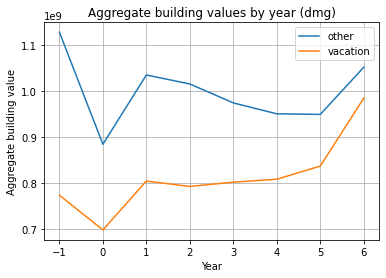

In [16]:
line1, = plt.plot(hr_collapse["year"].where(hr_collapse["d_vacationct"] == 0), hr_collapse.bval_year, label='other')
line2, = plt.plot(hr_collapse["year"].where(hr_collapse["d_vacationct"] == 1), hr_collapse.bval_year, label='vacation')
plt.legend(handles=[line1, line2])

plt.title("Aggregate building values by year (dmg)")
plt.xlabel("Year")
plt.ylabel("Aggregate building value")
plt.grid(True)
plt.show()